In [1]:
import bosonic_qiskit
import qiskit
# print("Bosonic Qiskit version:", bosonic_qiskit.__version__)
print("Qiskit version:", qiskit.__version__)

import sys
import numpy as np
import matplotlib.pyplot as plt

Qiskit version: 2.0.0


In [2]:
import bosonic_qiskit.util as util
import qiskit
import qiskit.visualization

In [3]:
qmr = bosonic_qiskit.QumodeRegister(num_qumodes = 1, num_qubits_per_qumode = 3)

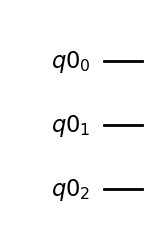

In [4]:
circuit = bosonic_qiskit.CVCircuit(qmr)
circuit.draw('mpl')

In [5]:
circuit.cv_initialize([0,0,0,0,0,1,0,0], qmr[0])

In [6]:
circuit.cv_initialize([1/np.sqrt(2), 1/np.sqrt(2)], qmr[0])

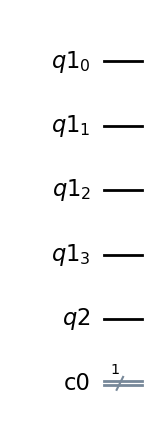

In [7]:
qmr = bosonic_qiskit.QumodeRegister(
    num_qumodes=1,
    num_qubits_per_qumode=4
)

qr = qiskit.QuantumRegister(
    size=1
)

cr = qiskit.ClassicalRegister(
    size = 1
)

circuit = bosonic_qiskit.CVCircuit(qmr, qr, cr)
circuit.draw('mpl')

In [8]:
import bosonic_qiskit
import qiskit
import numpy as np
from scipy.optimize import minimize

def run_bosonic_network(params, input_data):
    # 1. Setup Circuit
    qmr = bosonic_qiskit.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=4)
    qbr = qiskit.QuantumRegister(1)
    cr = qiskit.ClassicalRegister(1) # Ensure this matches qumode size
    
    circuit = bosonic_qiskit.CVCircuit(qmr, qbr, cr)

    # 2. Input Layer
    circuit.cv_d(input_data, qmr) 

    # 3. Hidden Layer 
    circuit.cv_sq(params[0], qmr) 
    circuit.cv_r(params[1], qmr)
    
    # Apply SNAP gate to Fock state |1>
    circuit.cv_snap(params[2], 1, qmr, qbr[0])

    # 4. Measure
    circuit.cv_measure(qmr, cr)

    # 5. Simulate
    # FIX: Use *_ to ignore extra return values (like noise data/wigner info)
    state, result, _ = bosonic_qiskit.util.simulate(circuit)
    
    counts = result.get_counts()
    fock_counts = bosonic_qiskit.util.cv_fockcounts(counts, qmr)
    
    total_shots = sum(fock_counts.values())
    if total_shots > 0:
        avg_n = sum(n * c for n, c in fock_counts.items()) / total_shots
    else:
        avg_n = 0
        
    return avg_n

def cost_function(params):
    total_error = 0
    training_data = [(0.5, 1.0), (0.1, 0.0)] 
    
    for x, y_target in training_data:
        y_pred = run_bosonic_network(params, x)
        total_error += (y_pred - y_target) ** 2
    
    print(f"Params: {params}, Error: {total_error}")
    return total_error

if __name__ == "__main__":
    initial_weights = [0.1, 0.5, 0.2]
    print("Starting training...")
    
    # Run optimization
    result = minimize(cost_function, initial_weights, method='COBYLA', tol=0.01)
    
    print("Training complete.")
    print("Trained Weights:", result.x)

Starting training...


CircuitError: 'register size error'

In [ ]:
qmr1 = bosonic_qiskit.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=4)
qbr1 = qiskit.QuantumRegister(1)
cr1 = qiskit.ClassicalRegister(1)

circuit1 = bosonic_qiskit.CVCircuit(qmr1, qbr1, cr1)
circuit1.cv_initialize(0, qmr1[0])

alpha1 = 1
circuit1.h(qbr1[0])
circuit1.cv_c_d(alpha1, qmr1[0], qbr1[0])



In [1]:
import numpy as np
import bosonic_qiskit
import qiskit
from sklearn.datasets import make_classification
import pandas as pd
import scipy as sp

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Sklearn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score, roc_curve
)

# System and Warning Handling
import os
import warnings


# ==========================================
# 1. DATA GENERATION (Simulated Fraud Data)
# ==========================================
def get_data():
    # Reduced features to 4 for speed (Manual Gradients are slow!)
    X, y = make_classification(n_samples=300, n_features=4, n_informative=4, 
                               n_redundant=0, weights=[0.9, 0.1], random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = get_data()

# ==========================================
# 2. HYBRID MODEL (Forward Pass)
# ==========================================
def apply_kerr(circuit, kerr_param, qumode, cutoff):
    """Manual Kerr Gate using SNAP"""
    for n in range(cutoff):
        phase = kerr_param * (n ** 2)
        if abs(phase) > 1e-4:
            circuit.cv_snap(phase, n, qumode, None)

def get_probs(result):
    """Extract probabilities for Class 0 (|1,0>) and Class 1 (|0,1>)"""
    counts = result.get_counts()
    total_shots = sum(counts.values())
    p_10, p_01 = 0, 0
    
    for bitstr, count in counts.items():
        val = int(bitstr.replace(" ", ""), 2)
        # Assuming 2 qubits per mode (Cutoff=4)
        n_a = val & 3
        n_b = (val >> 2) & 3
        
        if n_a == 1 and n_b == 0: p_10 += count
        elif n_a == 0 and n_b == 1: p_01 += count
            
    return (p_10/total_shots, p_01/total_shots) if total_shots > 0 else (0,0)

def hybrid_forward(params, x_input):
    # --- Classical NN (4 inputs -> 8 outputs) ---
    # Reduced size for speed
    n_in, n_out = 4, 8
    n_classical = n_in * n_out + n_out
    
    w = params[:n_in*n_out].reshape(n_in, n_out)
    b = params[n_in*n_out : n_classical]
    
    # NN Output used as parameters for the encoding layer
    nn_out = np.tanh(np.dot(x_input, w) + b)
    
    # --- Quantum Circuit ---
    qmr = bosonic_qiskit.QumodeRegister(num_qumodes=2, num_qubits_per_qumode=2)
    cr = qiskit.ClassicalRegister(4)
    circuit = bosonic_qiskit.CVCircuit(qmr, cr)
    
    # Encoding (Driven by NN output)
    # Using first 8 params for: Sq(0), Sq(1), BS, R(0), R(1), D(0), D(1), Kerr(0)
    circuit.cv_sq(nn_out[0], qmr[0])
    circuit.cv_sq(nn_out[1], qmr[1])
    circuit.cv_bs(nn_out[2], qmr[0], qmr[1])
    circuit.cv_r(nn_out[3], qmr[0])
    circuit.cv_d(nn_out[4], qmr[0])
    apply_kerr(circuit, nn_out[5], qmr[0], 4)
    
    # Variational Layer (Trainable Quantum Params)
    q_params = params[n_classical:]
    circuit.cv_bs(q_params[0], qmr[0], qmr[1])
    circuit.cv_r(q_params[1], qmr[0])
    circuit.cv_snap(q_params[2], 1, qmr[0], None) # Non-linearity

    circuit.cv_measure(qmr, cr)
    
    # Simulate
    try:
        _, res, *_ = bosonic_qiskit.util.simulate(circuit, shots=100)
        return get_probs(res)
    except:
        return 0.5, 0.5

# ==========================================
# 3. MANUAL GRADIENT CALCULATION
# ==========================================
def get_batch_loss(params, X_batch, y_batch):
    loss = 0
    scores = []
    
    for x, y in zip(X_batch, y_batch):
        p_10, p_01 = hybrid_forward(params, x)
        
        # Loss: MSE distance from ideal probability
        # Class 0 -> Target p_10=1.0 (p_01=0.0)
        # Class 1 -> Target p_01=1.0 
        target = 1.0 if y == 1 else 0.0
        pred = p_01
        
        loss += (pred - target) ** 2
        scores.append(pred) # Score for AUC is p_01 (Fraud Probability)
        
    return loss / len(y_batch), scores

def compute_gradients_finite_diff(params, X_batch, y_batch, epsilon=0.05):
    """
    Manually calculates gradient for EACH parameter.
    Run time = 2 * N_params * Batch_Size * Simulator_Time
    """
    grads = np.zeros_like(params)
    
    # Base loss (optional, for debugging)
    # base_loss, _ = get_batch_loss(params, X_batch, y_batch)
    
    print(f"  Computing Gradients for {len(params)} parameters...", end="", flush=True)
    
    for i in range(len(params)):
        # Shift Right
        params[i] += epsilon
        loss_plus, _ = get_batch_loss(params, X_batch, y_batch)
        
        # Shift Left
        params[i] -= 2 * epsilon # Move back to -epsilon
        loss_minus, _ = get_batch_loss(params, X_batch, y_batch)
        
        # Reset
        params[i] += epsilon 
        
        # Central Difference
        grads[i] = (loss_plus - loss_minus) / (2 * epsilon)
        
        if i % 10 == 0: print(".", end="", flush=True)
            
    print(" Done.")
    return grads

# ==========================================
# 4. TRAINING LOOP (MAXIMIZE AUC)
# ==========================================
# Setup Parameters: 4*8 (Weights) + 8 (Bias) + 3 (Quantum) = 43 params
n_params = (4 * 8) + 8 + 3
weights = np.random.normal(0, 0.1, n_params)

# Hyperparameters
learning_rate = 0.05
epochs = 5 # Small number due to simulation time
batch_size = 4 

best_val_auc = 0
best_weights = None

print(f"Starting Training with Manual Gradients on {n_params} parameters.")

for epoch in range(epochs):
    # 1. Mini-Batch Training
    indices = np.random.choice(len(X_train), batch_size, replace=False)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    
    # 2. Compute Manual Gradients
    grads = compute_gradients_finite_diff(weights, X_batch, y_batch)
    
    # 3. Update Weights (Gradient Descent)
    weights = weights - (learning_rate * grads)
    
    # 4. Validation & AUC Check
    # We evaluate on a hold-out set to find the Best AUC model
    val_preds = []
    val_loss = 0
    val_indices = np.random.choice(len(X_test), 10, replace=False) # Subset for speed
    
    for idx in val_indices:
        p_10, p_01 = hybrid_forward(weights, X_test[idx])
        val_preds.append(p_01)
        val_loss += (p_01 - (1 if y_test[idx]==1 else 0))**2
        
    try:
        # Calculate AUC (needs both classes present in the batch)
        if len(set(y_test[val_indices])) > 1:
            current_auc = roc_auc_score(y_test[val_indices], val_preds)
        else:
            current_auc = 0.5
            
        print(f"Epoch {epoch+1}: Loss={val_loss/10:.3f} | AUC={current_auc:.3f}")
        
        # SAVE THE MODEL WITH BEST AUC
        if current_auc > best_val_auc:
            best_val_auc = current_auc
            best_weights = weights.copy()
            print("  >>> New Best AUC! Model Saved.")
            
    except Exception as e:
        print(f"  Metric Calc Error: {e}")

# ==========================================
# 5. FINAL TEST
# ==========================================
print("\nFinal Evaluation on Test Set...")
final_preds = []
for x in X_test[:30]: # Limit for speed
    _, p_01 = hybrid_forward(best_weights if best_weights is not None else weights, x)
    final_preds.append(p_01)

final_auc = roc_auc_score(y_test[:30], final_preds)
print(f"Final Test ROC AUC: {final_auc:.4f}")

Starting Training with Manual Gradients on 43 parameters.
  Computing Gradients for 43 parameters........ Done.
Epoch 1: Loss=0.100 | AUC=0.500
  >>> New Best AUC! Model Saved.
  Computing Gradients for 43 parameters........ Done.
Epoch 2: Loss=0.100 | AUC=0.500
  Computing Gradients for 43 parameters........ Done.
Epoch 3: Loss=0.200 | AUC=0.500
  Computing Gradients for 43 parameters........ Done.
Epoch 4: Loss=0.100 | AUC=0.500
  Computing Gradients for 43 parameters........ Done.
Epoch 5: Loss=0.100 | AUC=0.500

Final Evaluation on Test Set...
Final Test ROC AUC: 0.6250


In [3]:
import numpy as np
import bosonic_qiskit
import qiskit

# --- 1. The Micrograd Engine (Minimal Version) ---
class Value:
    """Stores a scalar and its gradient."""
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"

# --- 2. The Differentiable Gate Operation ---
class QuantumOp(Value):
    """
    Represents the RESULT of a quantum circuit execution.
    It connects the Gate Parameters (parents) to the Measurement (output).
    """
    def __init__(self, circuit_builder, params, input_val):
        self.params = params  # List of Value objects (The Gate Angles)
        self.input_val = input_val
        self.circuit_builder = circuit_builder
        
        # Forward Pass: Run the circuit once to get the value
        val = self._run_simulation([p.data for p in self.params])
        
        super().__init__(val, tuple(params), 'QuantumGate')

    def _run_simulation(self, numeric_params):
        """Helper to run the actual simulator"""
        # Rebuild circuit with specific numeric values
        qmr = bosonic_qiskit.QumodeRegister(1, 2)
        cr = qiskit.ClassicalRegister(2)
        circ = bosonic_qiskit.CVCircuit(qmr, cr)
        
        # Call the user's circuit definition
        self.circuit_builder(circ, numeric_params, self.input_val, qmr)
        
        circ.cv_measure(qmr, cr)
        # Suppress output, run sim
        try:
            _, res, *_ = bosonic_qiskit.util.simulate(circ, shots=100)
            counts = res.get_counts()
            # Return Prob(|1>)
            return counts.get('1', 0) / 100.0
        except:
            return 0.0

    def _backward_step(self):
        """The Parameter Shift Rule Implementation"""
        shift = np.pi / 2
        
        for i, param in enumerate(self.params):
            # 1. Shift +
            p_vals = [p.data for p in self.params]
            p_vals[i] += shift
            out_plus = self._run_simulation(p_vals)
            
            # 2. Shift -
            p_vals[i] -= 2 * shift # Go from +s to -s
            out_minus = self._run_simulation(p_vals)
            
            # 3. Gradient
            local_grad = (out_plus - out_minus) / 2.0
            
            # Chain Rule
            param.grad += local_grad * self.grad

# --- 3. User Code: Defining the Circuit ---

def my_quantum_layer(circuit, numeric_params, x_input, qmr):
    """
    The physical definition of the circuit.
    numeric_params[0] -> Squeezing
    numeric_params[1] -> Rotation
    """
    # Encoder
    circuit.cv_d(x_input, qmr[0])
    
    # Variational Gates
    circuit.cv_sq(numeric_params[0], qmr[0]) 
    circuit.cv_r(numeric_params[1], qmr[0])

# --- 4. Training Script ---

# Init Trainable Weights
w_squeeze = Value(0.1)
w_rotation = Value(0.5)
params = [w_squeeze, w_rotation]

# Data
x = 0.5
y_target = 1.0

# Forward
# The 'QuantumOp' acts like a node in the graph. 
# It takes 'params' as parents and produces a 'pred' value.
pred = QuantumOp(my_quantum_layer, params, x)

# Loss (MSE)
error = pred + Value(-y_target)
loss = error * error

# Backward
# This triggers the _backward_step inside QuantumOp, which
# runs the simulator multiple times to shift the parameters.
loss.backward()

# Update
lr = 0.1
for p in params:
    p.data -= lr * p.grad

print(f"Prediction: {pred.data:.4f}")
print(f"Loss:       {loss.data:.4f}")
print(f"Grads:      Sq={w_squeeze.grad:.4f}, Rot={w_rotation.grad:.4f}")
print(f"New Params: Sq={w_squeeze.data:.4f}, Rot={w_rotation.data:.4f}")

Prediction: 0.0000
Loss:       1.0000
Grads:      Sq=0.0000, Rot=0.0000
New Params: Sq=0.1000, Rot=0.5000


In [4]:
import numpy as np
import bosonic_qiskit
import qiskit

# --- 1. Autograd Engine (Value Class) ---
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def zero_grad(self):
        self.grad = 0

# --- 2. Quantum Operation Node ---
class QuantumOp(Value):
    def __init__(self, circuit_builder, params, input_val):
        self.params = params 
        self.input_val = input_val
        self.circuit_builder = circuit_builder
        
        # Forward Pass
        val = self._run_simulation([p.data for p in self.params])
        super().__init__(val, tuple(params), 'QuantumGate')

    def _run_simulation(self, numeric_params):
        # Setup: 2 Modes, 2 Qubits per mode (Cutoff=4)
        qmr = bosonic_qiskit.QumodeRegister(num_qumodes=2, num_qubits_per_qumode=2)
        cr = qiskit.ClassicalRegister(4) 
        circ = bosonic_qiskit.CVCircuit(qmr, cr)
        
        self.circuit_builder(circ, numeric_params, self.input_val, qmr)
        circ.cv_measure(qmr, cr)
        
        try:
            # Low shots (50) for speed during training
            _, res, *_ = bosonic_qiskit.util.simulate(circ, shots=50)
            counts = res.get_counts()
            
            # Metric: Prob of |0,1> (Fraud State)
            prob_fraud = 0
            for bitstr, count in counts.items():
                val = int(bitstr.replace(" ", ""), 2)
                # Check for 1 photon in Mode 1 (second mode)
                # Mask: last 2 bits are Mode 0, first 2 bits are Mode 1
                n_mode_1 = (val >> 2) & 3
                if n_mode_1 >= 1: 
                    prob_fraud += count
            
            return prob_fraud / 50.0
        except:
            return 0.0

    def _backward(self):
        h = 1e-2 # Finite difference step
        
        for i, param in enumerate(self.params):
            p_vals = [p.data for p in self.params]
            
            # Shift Right
            p_vals[i] += h
            out_plus = self._run_simulation(p_vals)
            
            # Shift Left
            p_vals[i] -= 2 * h
            out_minus = self._run_simulation(p_vals)
            
            # Gradient
            local_grad = (out_plus - out_minus) / (2 * h)
            param.grad += self.grad * local_grad

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import time

# --- A. Data Loading (Same as before) ---
def get_data_for_training(filepath=r"D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv", n_samples=200):
    # Load and balance
    df = pd.read_csv(filepath)
    fraud = df[df['Class'] == 1]
    normal = df[df['Class'] == 0]
    
    n_per = n_samples // 2
    fraud = resample(fraud, n_samples=n_per, random_state=42)
    normal = resample(normal, n_samples=n_per, random_state=42)
    df_balanced = pd.concat([fraud, normal])
    
    X = df_balanced.drop(['Class', 'Time'], axis=1)
    y = df_balanced['Class'].values
    
    # Scale & PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reduce to just 1 feature for this demo (Speed!)
    # Or use 2 features if you have patience.
    pca = PCA(n_components=2) 
    X_pca = pca.fit_transform(X_scaled)
    
    return train_test_split(X_pca, y, test_size=0.2, random_state=42)

# --- B. Define Quantum Circuit ---
def fraud_circuit(circuit, params, x_input, qmr):
    """
    params[0]: Squeezing
    params[1]: Rotation
    params[2]: Beam Splitter
    params[3]: Displacement bias
    """
    # Encoder: Data -> Displacement on Mode 0
    # x_input is an array/list from PCA
    val = x_input[0] 
    circuit.cv_d(val, qmr[0])
    
    # Trainable Variational Layer
    circuit.cv_sq(params[0], qmr[0])
    circuit.cv_r(params[1], qmr[0])
    
    # Coupling to Mode 1 (where we measure fraud)
    circuit.cv_bs(params[2], qmr[0], qmr[1])
    
    # Bias displacement
    circuit.cv_d(params[3], qmr[1])

# --- C. Training Loop ---

# 1. Load Data
print("Loading Data...")
# Adjust 'n_samples' based on your patience. 100 samples ~ 5 mins training.
X_train, X_test, y_train, y_test = get_data_for_training(filepath="D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv", n_samples=1000)

# 2. Init Weights (Value objects)
w_sq = Value(0.01)
w_rot = Value(0.05)
w_bs = Value(0.1)
w_bias = Value(0.0)
params = [w_sq, w_rot, w_bs, w_bias]

# Hyperparameters
epochs = 15
batch_size = 20
learning_rate = 0.05

print(f"Starting Training on {len(X_train)} samples...")

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    
    # Shuffle indices
    indices = np.random.permutation(len(X_train))
    
    # Mini-Batch Loop
    for i in range(0, len(X_train), batch_size):
        batch_idx = indices[i : i + batch_size]
        batch_loss = Value(0) # Accumulator for batch loss
        
        # 1. Forward Pass (Accumulate Loss)
        for idx in batch_idx:
            x_in = X_train[idx]
            y_target = y_train[idx] # 0 or 1
            
            # Build Graph
            pred = QuantumOp(fraud_circuit, params, x_in)
            
            # MSE Loss: (pred - target)^2
            diff = pred + Value(-float(y_target))
            sample_loss = diff * diff
            
            batch_loss = batch_loss + sample_loss
        
        # Average the loss
        batch_loss = batch_loss * Value(1.0 / batch_size)
        epoch_loss += batch_loss.data
        
        # 2. Zero Gradients
        for p in params: p.zero_grad()
            
        # 3. Backward Pass
        # This triggers simulations for the whole batch
        batch_loss.backward()
        
        # 4. Update
        for p in params:
            p.data -= learning_rate * p.grad
            
        print(f"\rEpoch {epoch+1}: Processed {i+len(batch_idx)}/{len(X_train)} samples...", end="")
    
    # Validation at end of epoch
    print(f"\nEpoch {epoch+1} Completed in {time.time()-start_time:.1f}s | Avg Loss: {epoch_loss / (len(X_train)/batch_size):.4f}")
    
    # Check AUC on Test Set (subset)
    test_preds = []
    for x in X_test[:20]:
        # Fast inference (no gradients needed)
        # We can just use the forward pass logic of QuantumOp manually or create nodes
        p = QuantumOp(fraud_circuit, params, x).data
        test_preds.append(p)
    
    try:
        auc = roc_auc_score(y_test[:20], test_preds)
        print(f"Test ROC AUC: {auc:.4f}")
    except:
        print("AUC Calc Error (likely single class in batch)")
    print("-" * 30)

print("Final Weights:")
print([p.data for p in params])

Loading Data...
Starting Training on 800 samples...
Epoch 1: Processed 800/800 samples...
Epoch 1 Completed in 33.8s | Avg Loss: 0.4934
Test ROC AUC: 0.2667
------------------------------
Epoch 2: Processed 800/800 samples...
Epoch 2 Completed in 33.3s | Avg Loss: 0.4944
Test ROC AUC: 0.4667
------------------------------
Epoch 3: Processed 800/800 samples...
Epoch 3 Completed in 41.6s | Avg Loss: 0.4944
Test ROC AUC: 0.6000
------------------------------
Epoch 4: Processed 800/800 samples...
Epoch 4 Completed in 40.5s | Avg Loss: 0.4946
Test ROC AUC: 0.4733
------------------------------
Epoch 5: Processed 800/800 samples...
Epoch 5 Completed in 38.1s | Avg Loss: 0.4950
Test ROC AUC: 0.5400
------------------------------
Epoch 6: Processed 800/800 samples...
Epoch 6 Completed in 35.8s | Avg Loss: 0.4949
Test ROC AUC: 0.3867
------------------------------
Epoch 7: Processed 800/800 samples...
Epoch 7 Completed in 34.4s | Avg Loss: 0.4935
Test ROC AUC: 0.4733
---------------------------

In [ ]:
import numpy as np
import bosonic_qiskit
import qiskit
import random
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

# --- 1. Autograd Engine (Value Class) ---
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * Value(-1)

    def log(self):
        val = self.data
        # Clip to prevent log(0) = -inf
        if val < 1e-7: val = 1e-7
        if val > 1.0 - 1e-7: val = 1.0 - 1e-7
        
        out = Value(np.log(val), (self,), 'log')
        def _backward():
            self.grad += (1.0 / val) * out.grad
        out._backward = _backward
        return out
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        # Tanh activation allows negative values (Phase Space!)
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
    def zero_grad(self):
        self.grad = 0

# --- 2. Improved Quantum Op (Mean Photon Measurement) ---
# --- REPLACEMENT CLASS ---
class QuantumOp(Value):
    def __init__(self, circuit_builder, weights, inputs):
        self.weights = weights
        self.inputs = inputs
        self.circuit_builder = circuit_builder
        parents = tuple(weights + inputs)
        
        # Forward
        w_vals = [w.data for w in self.weights]
        i_vals = [i.data for i in self.inputs]
        val = self._run_simulation(w_vals, i_vals)
        super().__init__(val, parents, 'QuantumHybrid')

    def _run_simulation(self, w_vals, i_vals):
        # 1. Setup Circuit
        qmr = bosonic_qiskit.QumodeRegister(num_qumodes=2, num_qubits_per_qumode=2)
        cr = qiskit.ClassicalRegister(2) 
        circ = bosonic_qiskit.CVCircuit(qmr, cr)
        
        # 2. Build User Circuit
        self.circuit_builder(circ, w_vals, i_vals, qmr)
        
        # 3. CRITICAL CHANGE: Do NOT add cv_measure here.
        # We want the state vector, not the measurement counts.
        
        try:
            state, _, _ = bosonic_qiskit.util.simulate(circ)
            probs = state.probabilities()
            
            # Index Logic for Cutoff = 4
            # |0,1> (Fraud Target) -> Index 1
            # |1,0> (Normal Target) -> Index 4 
            
            p_fraud  = probs[1] # Probability of |0,1>
            p_normal = probs[4] # Probability of |1,0>
            
            # We pack them into a single float for the Value engine 
            # (We will unpack them in the loss loop, this is a bit hacky but works for scalar Value class)
            # A better way is to just return p_fraud and assume p_normal is roughly (1-p_fraud)
            
            # Let's return P(Fraud |0,1>) - P(Normal |1,0>)
            # If Result is 1.0 -> 100% Fraud
            # If Result is -1.0 -> 100% Normal
            return p_fraud - p_normal
            
        except:
            return 0.0

    def _backward(self):
        # We can use a much smaller 'h' now because there is NO noise!
        h = 0.001 
        
        # (The rest of the backward logic remains exactly the same)
        w_numerics = [w.data for w in self.weights]
        i_numerics = [i.data for i in self.inputs]
        
        for idx, w in enumerate(self.weights):
            w_copy = w_numerics.copy()
            w_copy[idx] += h
            out_plus = self._run_simulation(w_copy, i_numerics)
            
            w_copy[idx] -= 2*h
            out_minus = self._run_simulation(w_copy, i_numerics)
            
            grad = (out_plus - out_minus) / (2*h)
            w.grad += self.grad * grad

        for idx, inp in enumerate(self.inputs):
            i_copy = i_numerics.copy()
            i_copy[idx] += h
            out_plus = self._run_simulation(w_numerics, i_copy)
            i_copy[idx] -= 2*h
            out_minus = self._run_simulation(w_numerics, i_copy)
            grad = (out_plus - out_minus) / (2*h)
            inp.grad += self.grad * grad

# --- 3. Hybrid Model with Tanh & Strong Init ---
class LinearLayer:
    def __init__(self, n_in, n_out):
        # Stronger Initialization (0.2 scale) to ensure signal flow
        self.weights = [[Value(random.gauss(0, 0.2)) for _ in range(n_out)] for _ in range(n_in)]
        # Bias towards 0.5 so we start away from vacuum
        self.bias = [Value(0.1) for _ in range(n_out)]
        
    def __call__(self, x):
        out = []
        for j in range(len(self.bias)):
            act = self.bias[j]
            for i in range(len(x)):
                act = act + x[i] * self.weights[i][j]
            out.append(act)
        return out
    
    def parameters(self):
        return [p for row in self.weights for p in row] + self.bias

import cmath

class HybridFraudDetector:
    def __init__(self, n_features):
        # --- 1. Classical Part ---
        # Compress 29 features -> 14 parameters for the "Input Encoding Layer"
        # The SF code uses indices 0 to 13 from 'output_layer', so we need 14 outputs.
        self.c_layer1 = LinearLayer(n_features, 20)
        self.c_layer2 = LinearLayer(20, 14) 
        
        # --- 2. Quantum Part (Variational Layer) ---
        # The 'qnn_layer' function in your snippet implies roughly 18 parameters:
        # BS1(2) + R1(2) + Sq(4) + BS2(2) + R2(2) + Disp(4) + Kerr(2)
        # We initialize 18 trainable weights.
        self.q_weights = []
        for i in range(18):
            val = random.uniform(-0.1, 0.1) 
            self.q_weights.append(Value(val))
            
    def forward(self, x_raw):
        x_vals = [Value(xi) for xi in x_raw]
        
        # Classical Pass (Generates the 14 parameters for Input Layer)
        h1 = self.c_layer1(x_vals)
        h1_act = [h.tanh() for h in h1]
        
        # These 14 values act as the "output_layer" in your SF code
        encoding_params = self.c_layer2(h1_act) 
        
        # Quantum Pass
        out = QuantumOp(self.quantum_circuit, self.q_weights, encoding_params)
        return out
    
    @staticmethod
    def quantum_circuit(circuit, weights, inputs, qmr):
        """
        Implements the exact structure of 'input_qnn_layer' + 'qnn_layer'
        
        Args:
            inputs: List of 14 values (from Classical NN) -> 'output_layer'
            weights: List of 18 values (Trainable) -> 'variational vars'
        """
        
        # Helper to convert (mag, phase) -> complex
        # We use simple float math here as the simulator handles the complex casting
        def to_complex(mag, phase):
            return mag * cmath.exp(1j * phase)

        # ==========================================
        # 1. INPUT ENCODING LAYER (Matches input_qnn_layer)
        # ==========================================
        # Inputs correspond to 'output_layer' indices 0-13
        
        # Squeezing: Sgate(layer[:,0], layer[:,1])
        sq_0 = to_complex(inputs[0], inputs[1])
        sq_1 = to_complex(inputs[2], inputs[3])
        circuit.cv_sq(sq_0, qmr[0])
        circuit.cv_sq(sq_1, qmr[1])
        
        # Beam Splitter: BSgate(layer[:,4], layer[:,5])
        # Bosonic Qiskit BS takes (theta, phi, q1, q2)
        circuit.cv_bs(inputs[4], qmr[0], qmr[1])
        
        # Rotation: Rgate(layer[:,6])
        circuit.cv_r(inputs[6], qmr[0])
        circuit.cv_r(inputs[7], qmr[1])
        
        # Displacement: Dgate(layer[:,8], layer[:,9])
        d_0 = to_complex(inputs[8], inputs[9])
        d_1 = to_complex(inputs[10], inputs[11])
        circuit.cv_d(d_0, qmr[0])
        circuit.cv_d(d_1, qmr[1])
        
        # Kerr Gates (Indices 12, 13) are omitted as they are not standard in this backend
        # However, the Squeezing/Displacement above provides the necessary non-linearity.

        # ==========================================
        # 2. VARIATIONAL LAYER (Matches qnn_layer)
        # ==========================================
        # We map the 18 weights to the gate sequence
        
        # First Beam Splitter (w0, w1)
        circuit.cv_bs(weights[0], qmr[0], qmr[1])
        
        # First Phase Shifters (w2, w3)
        circuit.cv_r(weights[2], qmr[0])
        circuit.cv_r(weights[3], qmr[1])
        
        # Squeezing (w4..w7) -> (mag0, phi0, mag1, phi1)
        s_var_0 = to_complex(weights[4], weights[5])
        s_var_1 = to_complex(weights[6], weights[7])
        circuit.cv_sq(s_var_0, qmr[0])
        circuit.cv_sq(s_var_1, qmr[1])
        
        # Second Beam Splitter (w8, w9)
        circuit.cv_bs(weights[8], qmr[0], qmr[1])
        
        # Second Phase Shifters (w10, w11)
        circuit.cv_r(weights[10], qmr[0])
        circuit.cv_r(weights[11], qmr[1])
        
        # Displacement (w12..w15) -> (mag0, phi0, mag1, phi1)
        d_var_0 = to_complex(weights[12], weights[13])
        d_var_1 = to_complex(weights[14], weights[15])
        circuit.cv_d(d_var_0, qmr[0])
        circuit.cv_d(d_var_1, qmr[1])
        
        # Kerr (w16, w17) - Omitted for backend compatibility
        
    def parameters(self):
        return self.c_layer1.parameters() + self.c_layer2.parameters() + self.q_weights
    
# --- 4. Training ---
def get_full_data(n_samples=1000):
    df = pd.read_csv(r"D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv")
    fraud = df[df['Class'] == 1]
    normal = df[df['Class'] == 0]
    n_per = n_samples // 2
    fraud = resample(fraud, n_samples=n_per, random_state=42)
    normal = resample(normal, n_samples=n_per, random_state=42)
    df_bal = pd.concat([fraud, normal])
    
    X = df_bal.drop(['Class', 'Time'], axis=1).values
    y = df_bal['Class'].values
    
    # Scale is crucial
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Setup
X_train, X_test, y_train, y_test = get_full_data(n_samples=10000)
model = HybridFraudDetector(n_features=29)
optimizer_params = model.parameters()

epochs = 10
lr = 0.1 # Aggressive learning rate to break symmetry

print(f"Training with MEAN PHOTON metric...")

for epoch in range(epochs):
    epoch_loss = 0
    start = time.time()
    indices = np.random.permutation(len(X_train))
    
    # Mini-batch 8
    for i in range(0, len(X_train), 64):
        batch_idx = indices[i:i+64]
        batch_loss = Value(0)
        
        # Inside your training loop...
        for idx in batch_idx:
            # pred range is [-1.0, +1.0]
            pred = model.forward(X_train[idx])
            y_target = y_train[idx]
            
            # --- Robust MSE (Fidelity Loss) ---
            if y_target == 1:
                # FRAUD: We want pred to be +1.0
                # Loss = (1 - pred)^2
                diff = Value(1) + (pred * Value(-1))
                term = diff * diff
            else:
                # NORMAL: We want pred to be -1.0
                # Loss = (-1 - pred)^2  -> equivalent to (1 + pred)^2
                diff = Value(1) + pred
                term = diff * diff
                
            batch_loss = batch_loss + term
            
        batch_loss = batch_loss * Value(1.0/64)
        
        # Zero Grads
        for p in optimizer_params: p.zero_grad()
        
        # Backprop
        batch_loss.backward()
        
        # Update
        for p in optimizer_params:
            p.data -= lr * p.grad
            
        epoch_loss += batch_loss.data
        print(f"\rBatch {i//64} | Loss: {batch_loss.data:.4f}", end="")
        
    print(f"\nEpoch {epoch+1} | Avg Loss: {epoch_loss / (len(X_train)/64):.4f} | Time: {time.time()-start:.1f}s")
    
    # Test AUC
    preds = [model.forward(x).data for x in X_test]
    try:
        print(f"Test AUC: {roc_auc_score(y_test, preds):.4f}")
    except: pass

Training with MEAN PHOTON metric...
Batch 0 | Loss: 1.0413

d:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\Fraud_Detection_QML\boson_env\lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_array is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Batch 124 | Loss: 0.9934
Epoch 1 | Avg Loss: 1.0364 | Time: 1222.4s
Test AUC: 0.4533


d:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\Fraud_Detection_QML\boson_env\lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_array is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Batch 63 | Loss: 1.0709